In [23]:
import numpy as np
import tensorflow as tf

In [24]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
print(train_images.shape)
print(train_labels.shape)

(60000, 28, 28)
(60000,)


In [25]:
def preprocess_images(images):
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.0
    return tf.cast(images, tf.float32)

X_train = preprocess_images(train_images)
X_test = preprocess_images(test_images)
print(X_train.shape)

(60000, 28, 28, 1)


In [26]:
train_ds = tf.data.Dataset.from_tensor_slices(X_train).shuffle(60000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices(X_test).shuffle(10000).batch(32)

In [27]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=(2,2), activation='relu'),
            tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=(2,2), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim + latent_dim)
        ])

        self.decoder = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation='relu'),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(32, kernel_size=(3,3), strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(32, kernel_size=(3,3), strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(1, kernel_size=(3,3), strides=1, padding='same')
        ])

    def encode(self, X):
        mean, log_var = tf.split(self.encoder(X), num_or_size_splits=2, axis=1)
        return mean, log_var
    
    def decode(self, Z, apply_sigmoid=False):
        logits = self.decoder(Z)
        if apply_sigmoid == True:
            probs = tf.sigmoid(logits)
            return probs
        return logits

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

In [28]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)


def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [29]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [30]:
import matplotlib.pyplot as plt
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

Epoch: 1, Test set ELBO: -174.27749633789062, time elapse for current epoch: 18.723339557647705


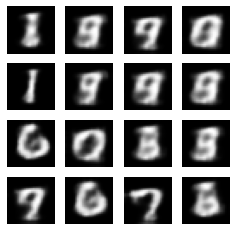

Epoch: 2, Test set ELBO: -169.912109375, time elapse for current epoch: 21.08155369758606


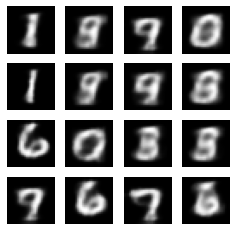

Epoch: 3, Test set ELBO: -167.0625, time elapse for current epoch: 19.405670404434204


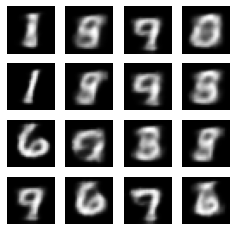

Epoch: 4, Test set ELBO: -165.17080688476562, time elapse for current epoch: 19.945984363555908


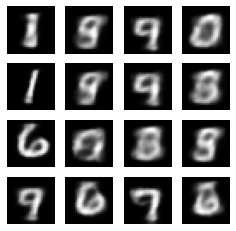

Epoch: 5, Test set ELBO: -163.61862182617188, time elapse for current epoch: 18.522024631500244


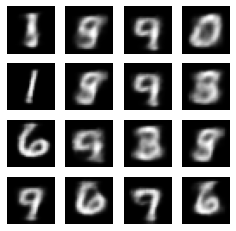

Epoch: 6, Test set ELBO: -162.58163452148438, time elapse for current epoch: 19.33340096473694


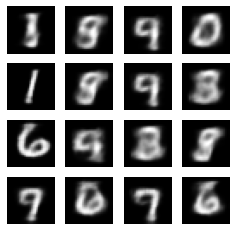

Epoch: 7, Test set ELBO: -161.84548950195312, time elapse for current epoch: 19.664061784744263


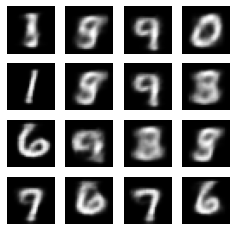

Epoch: 8, Test set ELBO: -161.17837524414062, time elapse for current epoch: 19.77122402191162


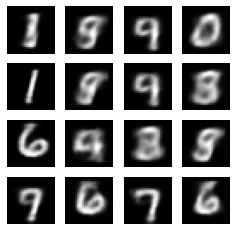

Epoch: 9, Test set ELBO: -160.65045166015625, time elapse for current epoch: 19.9419846534729


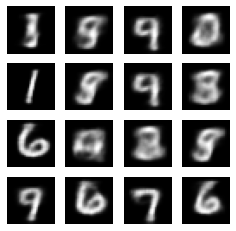

Epoch: 10, Test set ELBO: -160.41958618164062, time elapse for current epoch: 19.92981481552124


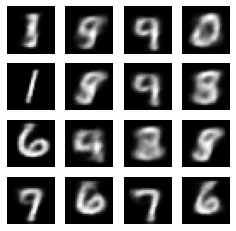

In [34]:
import time
for test_batch in test_ds.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]
for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_ds:
        train_step(model, train_x, optimizer)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for test_x in test_ds:
        loss(compute_loss(model, test_x))
    elbo = -loss.result()
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'.format(epoch, elbo, end_time - start_time))
    generate_and_save_images(model, epoch, test_sample)